In [1]:
!pip install wordcloud
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [55]:
# Imports required libraries

# for data wrangling
import numpy as np
import pandas as pd
import re, datetime
import string

# for NLP / sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# for model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# for exporting cleaned data
import os
from os.path import join
from joblib import dump, load

# for local helper funtions
import helper_module

#unused: 
from sklearn.svm import SVR



[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
reviews_df = pd.read_csv("Reviews_cleanText_noSW_sageMakerLocal.csv")

In [4]:
reviews_df.head()

,Text,Summary,Score,cleaned_text,cleaned_summary,Score_class,tokenized_reviews
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,5,buy several vitality can dog food products fin...,good quality dog food,1,"['buy', 'several', 'vitality', 'can', 'dog', '..."
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,1,product arrive label jumbo salt peanutsthe pea...,advertise,-1,"['product', 'arrive', 'label', 'jumbo', 'salt'..."
2,This is a confection that has been around a fe...,"""Delight"" says it all",4,confection around centuries light pillowy citr...,delight say,1,"['confection', 'around', 'centuries', 'light',..."
3,If you are looking for the secret ingredient i...,Cough Medicine,2,look secret ingredient robitussin believe find...,cough medicine,-1,"['look', 'secret', 'ingredient', 'robitussin',..."
4,Great taffy at a great price. There was a wid...,Great taffy,5,great taffy great price wide assortment yummy ...,great taffy,1,"['great', 'taffy', 'great', 'price', 'wide', '..."


In [5]:
assert(reviews_df.isna().sum().sum() == 0)

## Generate blanced data (OverSampler)

In [6]:
%%time

X_train, X_test, y_train, y_test = train_test_split(reviews_df["cleaned_text"], 
                                                    reviews_df["Score_class"], 
                                                    test_size=0.2,
                                                    random_state=42)
ros = RandomOverSampler(random_state=42)
X_res_train, y_res_train = ros.fit_resample(X_train.array.reshape(-1, 1), y_train)

X_res_train = pd.Series(X_res_train[:,0])

print("%d items in training data, %d in test data" % (len(X_train), len(X_test)))

315241 items in training data, 78811 in test data
CPU times: user 167 ms, sys: 8.54 ms, total: 176 ms
Wall time: 176 ms


In [7]:
assert(X_res_train.isna().sum().sum() == 0)

## TFIDF Vectorizer

In [9]:
count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 2))
count_vect = count_vect.fit(X_res_train)
X_train_counts = count_vect.transform(X_res_train)

tfidf_transformer = TfidfTransformer()
tfidf_transformer = tfidf_transformer.fit(X_train_counts)
X_train_tfidf = tfidf_transformer.transform(X_train_counts)

X_new_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

## Perform grid search on Multinomial Naive Bayes classifier

In [10]:
param_dict = {'alpha': [1e-9, 0.1, 0.5, 1],
              'fit_prior': np.array([True, False], dtype='bool')}
mnb = MultinomialNB(force_alpha=False)
mnb_cv = GridSearchCV(mnb, param_grid=param_dict,
                      scoring=['accuracy', 'f1', 'roc_auc', 'recall'],
                      refit='roc_auc',
                      return_train_score=True,
                      verbose=2)
mnb_cv.fit(X_train_tfidf, y_res_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ........................alpha=1e-09, fit_prior=True; total time=   1.0s
[CV] END ........................alpha=1e-09, fit_prior=True; total time=   1.1s
[CV] END ........................alpha=1e-09, fit_prior=True; total time=   1.0s
[CV] END ........................alpha=1e-09, fit_prior=True; total time=   1.0s
[CV] END ........................alpha=1e-09, fit_prior=True; total time=   1.1s
[CV] END .......................alpha=1e-09, fit_prior=False; total time=   1.1s
[CV] END .......................alpha=1e-09, fit_prior=False; total time=   1.0s
[CV] END .......................alpha=1e-09, fit_prior=False; total time=   1.1s
[CV] END .......................alpha=1e-09, fit_prior=False; total time=   1.1s
[CV] END .......................alpha=1e-09, fit_prior=False; total time=   1.1s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   1.1s
[CV] END ..........................alpha=0.1, fit

GridSearchCV(estimator=MultinomialNB(force_alpha=False),
             param_grid={'alpha': [1e-09, 0.1, 0.5, 1],
                         'fit_prior': array([ True, False])},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'roc_auc', 'recall'], verbose=2)

In [11]:
mnb_cv.best_score_

0.9928193854737575

In [12]:
mnb_cv.best_params_

{'alpha': 0.1, 'fit_prior': True}

In [13]:
mnb_cv_results = pd.DataFrame(mnb_cv.cv_results_)

              mean_train_accuracy  std_train_accuracy
param_alpha                                          
1.000000e-09             0.997297            0.000084
1.000000e-01             0.991542            0.000168
5.000000e-01             0.971889            0.000307
1.000000e+00             0.954506            0.000339
                 mean_train_accuracy  std_train_accuracy
param_fit_prior                                         
False                       0.978808            0.000742
True                        0.978809            0.000741


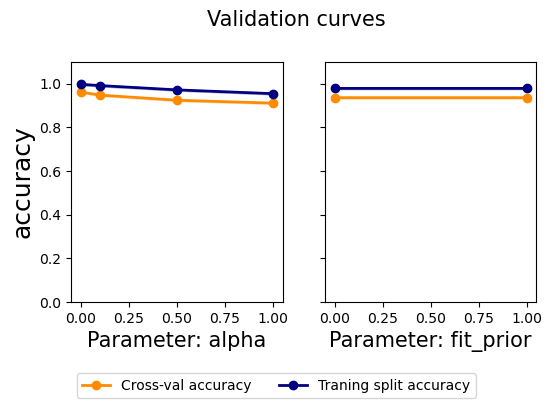

In [26]:
metric = 'accuracy'
p1 = helper_module.metric_cv_plot_multiParam(mnb_cv_results, metric, param_dict)
p1.savefig(f'mNB_cv_{metric}_scores.png', bbox_inches = "tight")

              mean_train_recall  std_train_recall
param_alpha                                      
1.000000e-09           0.997644          0.000060
1.000000e-01           0.989599          0.000210
5.000000e-01           0.957041          0.000337
1.000000e+00           0.927685          0.000300
                 mean_train_recall  std_train_recall
param_fit_prior                                     
False                     0.967992          0.000751
True                      0.967993          0.000751


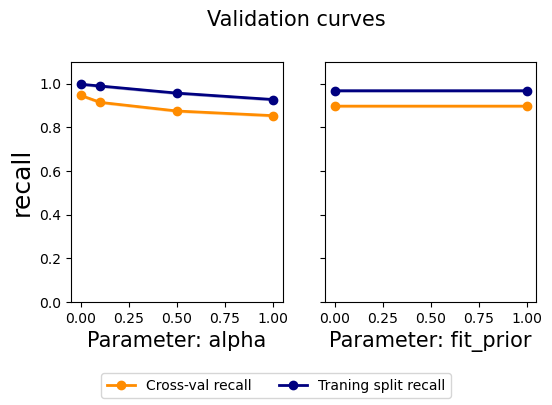

In [27]:
metric = 'recall'
p1 = helper_module.metric_cv_plot_multiParam(mnb_cv_results, metric, param_dict)
p1.savefig(f'mNB_cv_{metric}_scores.png', bbox_inches = "tight")

              mean_train_f1  std_train_f1
param_alpha                              
1.000000e-09       0.997298      0.000084
1.000000e-01       0.991525      0.000168
5.000000e-01       0.971466      0.000312
1.000000e+00       0.953252      0.000346
                 mean_train_f1  std_train_f1
param_fit_prior                             
False                 0.978385      0.000754
True                  0.978386      0.000753


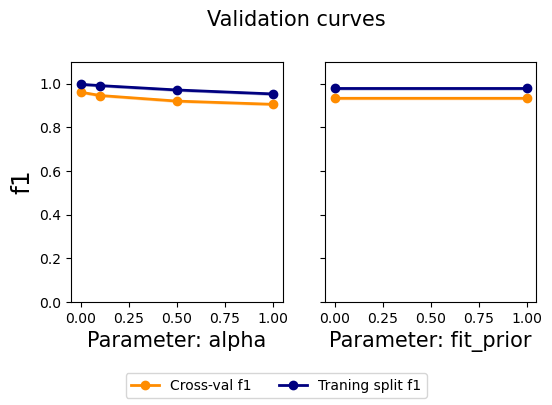

In [28]:
metric = 'f1'
p1 = helper_module.metric_cv_plot_multiParam(mnb_cv_results, metric, param_dict)
p1.savefig(f'mNB_cv_{metric}_scores.png', bbox_inches = "tight")

              mean_train_roc_auc  std_train_roc_auc
param_alpha                                        
1.000000e-09            0.999968           0.000001
1.000000e-01            0.999569           0.000015
5.000000e-01            0.996825           0.000106
1.000000e+00            0.992882           0.000221
                 mean_train_roc_auc  std_train_roc_auc
param_fit_prior                                       
False                      0.997311           0.000368
True                       0.997311           0.000368


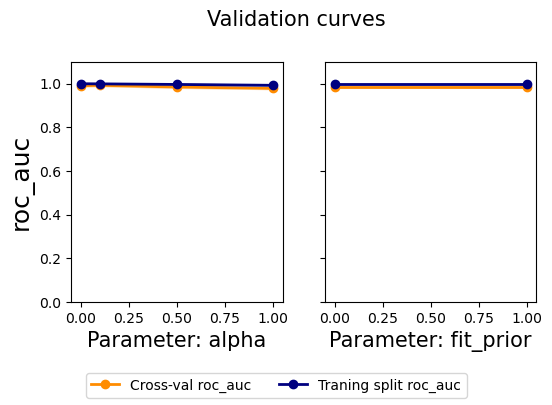

In [29]:
metric = 'roc_auc'
p1 = helper_module.metric_cv_plot_multiParam(mnb_cv_results, metric, param_dict)
p1.savefig(f'mNB_cv_{metric}_scores.png', bbox_inches = "tight")

### Refit with best params


In [ ]:
prrint(mnb_cv.best_params_)

In [34]:
mnb_best = MultinomialNB(alpha=0.1, fit_prior=True, force_alpha=False)
mnb_best.fit(X_train_tfidf, y_res_train)
y_pred = mnb_best.predict(X_test_tfidf)

In [45]:
auc, acc, f1, recall, cm = model_eval(y_test, y_pred)

AUC Score: 0.8194321796657568
Accuracy Score: 0.8746241006966032
F1 Score: 0.9194905932486495
Recall: 0.91803198672372
[[12505  4843]
 [ 5038 56425]]


In [46]:
name='MultinomialNB_best_noSW'
add_model_scores_to_results(file_path = 'Model_results.csv', 
                            model_name = name,
                            datashift = 'none', with_sw = 0,
                            ROC_AUC = auc, accuracy = acc, 
                            f1 = f1, recall=recall, cm = cm, first_entry=True)

MultinomialNB_best_noSW saved successfully!


## Test on data from shifted distributions

### 1. Review summaries: no stopwords

In [47]:
X_train, X_test, y_train, y_test = train_test_split(reviews_df["cleaned_summary"], 
                                                    reviews_df["Score_class"], 
                                                    test_size=0.2,
                                                    random_state=42)

In [48]:
X_new_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

In [49]:
y_pred = mnb_best.predict(X_test_tfidf)

In [50]:
auc, acc, f1, recall, cm = helper_module.model_eval(y_test, y_pred)

AUC Score: 0.7753612255502486
Accuracy Score: 0.8197586631307813
F1 Score: 0.8808974821199493
Recall: 0.8546767974228398
[[12075  5273]
 [ 8932 52531]]


In [51]:
name = 'MultinomialNB_best_noSW_Summary'
helper_module.add_model_scores_to_results(file_path = 'Model_results.csv', 
                            model_name = name,
                            datashift = 'summary', with_sw = 0,
                            ROC_AUC = auc, accuracy = acc, 
                            f1 = f1, recall=recall, cm = cm, first_entry=False)

MultinomialNB_best_noSW_Summary saved successfully!


### 2. Random Dropout on cleaned summary text

In [53]:
%%time
X_train, X_test, y_train, y_test = train_test_split(reviews_df["cleaned_text"], 
                                                    reviews_df["Score_class"], 
                                                    test_size=0.2,
                                                    random_state=42)

CPU times: user 65.7 ms, sys: 31 µs, total: 65.7 ms
Wall time: 64.5 ms


In [58]:
for i in [0.1, 0.25, 0.5]:
    X_test_dropout = X_test.apply(helper_module.random_dropout,
                                  p=i, random_state=42)
    X_new_counts = count_vect.transform(X_test_dropout)
    X_test_tfidf = tfidf_transformer.transform(X_new_counts)
    y_pred = mnb_best.predict(X_test_tfidf)
    auc, acc, f1, recall, cm = helper_module.model_eval(y_test, y_pred)
    name = f'MultinomialNB_best_SW+Dropout{i}'
    helper_module.add_model_scores_to_results(file_path = 'Model_results.csv', 
                                model_name = name,
                                datashift = f'dropout_{i}', with_sw = 0,
                                ROC_AUC = auc, accuracy = acc, 
                                f1 = f1, recall=recall, cm = cm, first_entry=False)

AUC Score: 0.6204992464859354
Accuracy Score: 0.6492621588356955
F1 Score: 0.7492425204564834
Recall: 0.6718838976294681
[[ 9873  7475]
 [20167 41296]]
MultinomialNB_best_SW+Dropout0.1 saved successfully!
AUC Score: 0.7266662895479339
Accuracy Score: 0.7921736813388994
F1 Score: 0.8636117610811801
Recall: 0.8436945804793128
[[10576  6772]
 [ 9607 51856]]
MultinomialNB_best_SW+Dropout0.25 saved successfully!
AUC Score: 0.768341192791338
Accuracy Score: 0.8305566481836292
F1 Score: 0.8900597698121285
Recall: 0.8794884727396971
[[11401  5947]
 [ 7407 54056]]
MultinomialNB_best_SW+Dropout0.5 saved successfully!


### 3. Cleaned reviews: with Stopwords

In [59]:
reviews_sw_df = pd.read_csv('Reviews_cleanText_SW_sageMakerLocal.csv')
reviews_sw_df.head()

,Unnamed: 0,Text,Summary,Score,cleaned_text,cleaned_summary,Score_class
0,0,I have bought several of the Vitality canned d...,Good Quality Dog Food,5,i have buy several of the vitality can dog foo...,good quality dog food,1
1,1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,1,product arrive label as jumbo salt peanutsthe ...,not as advertise,-1
2,2,This is a confection that has been around a fe...,"""Delight"" says it all",4,this be a confection that have be around a few...,delight say it all,1
3,3,If you are looking for the secret ingredient i...,Cough Medicine,2,if you be look for the secret ingredient in ro...,cough medicine,-1
4,4,Great taffy at a great price. There was a wid...,Great taffy,5,great taffy at a great price there be a wide a...,great taffy,1


In [60]:
reviews_sw_df.dropna(inplace=True)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(reviews_sw_df["cleaned_text"], 
                                                    reviews_sw_df["Score_class"], 
                                                    test_size=0.2,
                                                    random_state=42)

In [62]:
X_new_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

In [63]:
y_pred = mnb_best.predict(X_test_tfidf)

In [64]:
auc, acc, f1, recall, cm = helper_module.model_eval(y_test, y_pred)

AUC Score: 0.9176117335507923
Accuracy Score: 0.936826510326314
F1 Score: 0.9591811688471074
Recall: 0.9519610231425092
[[15367  2031]
 [ 2958 58617]]


In [65]:
name = 'MultinomialNB_best_SW'
helper_module.add_model_scores_to_results(file_path = 'Model_results.csv', 
                            model_name = name,
                            datashift = 'stopwords', with_sw = 1,
                            ROC_AUC = auc, accuracy = acc, 
                            f1 = f1, recall=recall, cm = cm, first_entry=False)

MultinomialNB_best_SW saved successfully!


### Summary with stopwords

In [66]:
X_train, X_test, y_train, y_test = train_test_split(reviews_sw_df["cleaned_summary"], 
                                                    reviews_sw_df["Score_class"], 
                                                    test_size=0.2,
                                                    random_state=42)

In [67]:
X_new_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

In [68]:
y_pred = mnb_best.predict(X_test_tfidf)

In [69]:
auc, acc, f1, recall, cm = helper_module.model_eval(y_test, y_pred)

AUC Score: 0.7695031335591096
Accuracy Score: 0.814607524090512
F1 Score: 0.8773117693886957
Recall: 0.8501339829476249
[[11985  5413]
 [ 9228 52347]]


In [70]:
name = 'MultinomialNB_best_Summary+SW'
helper_module.add_model_scores_to_results(file_path = 'Model_results.csv', 
                            model_name = name,
                            datashift = 'summary+stopwords', with_sw = 1,
                            ROC_AUC = auc, accuracy = acc, 
                            f1 = f1, recall=recall, cm = cm, first_entry=False)

MultinomialNB_best_Summary+SW saved successfully!


### 5. Random dropout on review text with stopwords

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reviews_sw_df["cleaned_text"], 
                                                    reviews_sw_df["Score_class"], 
                                                    test_size=0.2,
                                                    random_state=42)

In [72]:
for i in [0.1, 0.25, 0.5]:
    X_test_dropout = X_test.apply(helper_module.random_dropout, p=i, random_state=42)
    X_new_counts = count_vect.transform(X_test_dropout)
    X_test_tfidf = tfidf_transformer.transform(X_new_counts)
    y_pred = mnb_best.predict(X_test_tfidf)
    auc, acc, f1, recall, cm = helper_module.model_eval(y_test, y_pred)
    name = f'MultinomialNB_best_SW+Dropout{i}'
    helper_module.add_model_scores_to_results(file_path = 'Model_results.csv', 
                                model_name = name,
                                datashift = f'dropout_{i}', with_sw = 1,
                                ROC_AUC = auc, accuracy = acc, 
                                f1 = f1, recall=recall, cm = cm, first_entry=False)

AUC Score: 0.5095224370691989
Accuracy Score: 0.27888012358654224
F1 Score: 0.1737061273051755
Recall: 0.09721477872513196
[[16038  1360]
 [55589  5986]]
MultinomialNB_best_SW+Dropout0.1 saved successfully!
AUC Score: 0.7287867128524579
Accuracy Score: 0.7476099426386233
F1 Score: 0.8248906225291233
Recall: 0.762436053593179
[[12094  5304]
 [14628 46947]]
MultinomialNB_best_SW+Dropout0.25 saved successfully!
AUC Score: 0.7418036840631622
Accuracy Score: 0.7695161637521685
F1 Score: 0.8426194922874732
Recall: 0.7913438895655704
[[12044  5354]
 [12848 48727]]
MultinomialNB_best_SW+Dropout0.5 saved successfully!


Noting here that as I have it written dropout proportion is actually 1 - {i}, which explains why the scores are worse for smaller values of p. This is because np.random.binomial returns 1 with probability p. So p*(words_in_sentence) words are retained. Should try this with larger values of p.